This Jupyter Notebook is prepared by: name

# 1 - Load Data and Perform Basic EDA

## I - Import Libraries

In [61]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib as mpt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
import scipy.stats as spt
import sklearn as skl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.svm import SVC
import sklearn.tree as skt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import collections
import imblearn as iml
from imblearn.over_sampling import SMOTE

## II - Import Data to DataFrame && Show count of Rows and Columns

In [62]:
data = pd.read_csv('hrdata2.csv')
data.shape

(8955, 15)

## III - Show Top 5 and Last 5 Rows

In [63]:
print(data.head, data.tail)

<bound method NDFrame.head of       Unnamed: 0  enrollee_id      city  city_development_index  gender  \
0              1        29725   city_40                   0.776    Male   
1              4          666  city_162                   0.767    Male   
2              7          402   city_46                   0.762    Male   
3              8        27107  city_103                   0.920    Male   
4             11        23853  city_103                   0.920    Male   
...          ...          ...       ...                     ...     ...   
8950       19147        21319   city_21                   0.624    Male   
8951       19149          251  city_103                   0.920    Male   
8952       19150        32313  city_160                   0.920  Female   
8953       19152        29754  city_103                   0.920  Female   
8954       19155        24576  city_103                   0.920    Male   

          relevent_experience enrolled_university education_level  \


## IV - Show How Many Rows have Null Values

In [64]:
data.isnull().sum().sort_values(ascending = False)

Unnamed: 0                0
enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

## V - Plot the Count of Target and Discess its Imbalances and Probabsy Issues and Solutiens

(array([7472.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1483.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

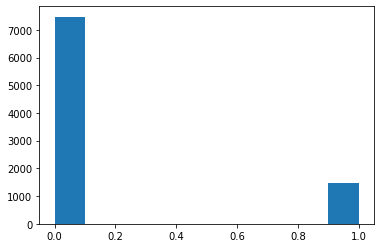

In [65]:
plt.hist(data.target)

there are a large number of '0' features compared to the '1' features

this can cause issues with the classifiers favoring the large number of '0's

we can attempt to ballence the '0's and '1's by coming up ith additional data or by limiting the number of '0' features we use

# 2 - Feature Selection and Pre-Processing

## I - Pre-Processing City

### A - Plot # of Records per City so that the Highest City Counts are Shown in Decending Order

(array([6556.,  901.,  585.,  356.,  228.,  123.,   91.,   60.,   39.,
          16.]),
 array([  0. ,  11.5,  23. ,  34.5,  46. ,  57.5,  69. ,  80.5,  92. ,
        103.5, 115. ]),
 <BarContainer object of 10 artists>)

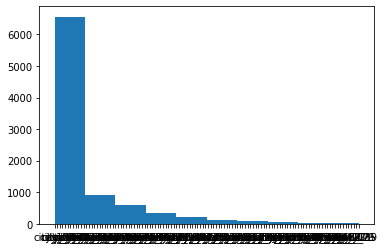

In [66]:
counts = collections.Counter(data.city)
new = sorted(data.city, key = lambda x: -counts[x])
plt.hist(new)

### B - How many rows belong to the count-wise top 4 cities in total and how many for the remaining?

In [67]:
countsDF = pd.DataFrame.from_dict(counts, orient = 'index')
countsDF.sort_values(0, axis = 0, ascending = False, inplace = True,)
top4 = countsDF.iloc[0:4, 0].sum()
others = countsDF.iloc[5:, 0].sum()
print('Sum of Top 4: ' + str(top4))
print('Sum of Others: ' + str(others))

Sum of Top 4: 5021
Sum of Others: 3533


### C - Replace the city name with city_others if the city name is not within the top 4 city names.

In [68]:
data['city'].mask((data['city'] != 'city_103') & (data['city'] != 'city_21') & (data['city'] != 'city_16') & (data['city'] != 'city_16'),
					  'city_other', inplace = True)

### D - Show some sample data that the records have changed appropriately

In [69]:
data.head()

,Unnamed: 0,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,1,29725,city_other,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,>4,47,0.0
1,4,666,city_other,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21.0,50-99,Funded Startup,4,8,0.0
2,7,402,city_other,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13.0,<10,Pvt Ltd,>4,18,1.0
3,8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7.0,50-99,Pvt Ltd,1,46,1.0
4,11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5.0,5000-9999,Pvt Ltd,1,108,0.0


## II - Education Level

### A - Show the unique values of education level.

In [70]:
data['education_level'].unique()

array(['Graduate', 'Masters', 'Phd'], dtype=object)

### B - Replace the value of Education level column like ordinal values, "Graduate" -> 0, Masters->1, and Phd -> 2

In [71]:
data['education_level'].mask(data['education_level'] == 'Graduate', 0, inplace = True)
data['education_level'].mask(data['education_level'] == 'Masters', 1, inplace = True)
data['education_level'].mask(data['education_level'] == 'Phd', 2, inplace = True)

### C - Show some sample data that the records have changed appropriately

In [72]:
data.head()

,Unnamed: 0,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,1,29725,city_other,0.776,Male,No relevent experience,no_enrollment,0,STEM,15.0,50-99,Pvt Ltd,>4,47,0.0
1,4,666,city_other,0.767,Male,Has relevent experience,no_enrollment,1,STEM,21.0,50-99,Funded Startup,4,8,0.0
2,7,402,city_other,0.762,Male,Has relevent experience,no_enrollment,0,STEM,13.0,<10,Pvt Ltd,>4,18,1.0
3,8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,0,STEM,7.0,50-99,Pvt Ltd,1,46,1.0
4,11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,0,STEM,5.0,5000-9999,Pvt Ltd,1,108,0.0


## III - Company Size

### A - Show the unique values of the company_size column

In [73]:
data['company_size'].unique()

array(['50-99', '<10', '5000-9999', '1000-4999', '10/49', '100-500',
       '10000+', '500-999'], dtype=object)

### B - Change the values of the company_size column from 0 to 7 where e0 is <10 and 7 is 10000+. The order of the numbers should be based on the values of the column-like an ordinary variable.

In [74]:
data['company_size'].mask(data['company_size'] == '<10', 0, inplace = True)
data['company_size'].mask(data['company_size'] == '10/49', 1, inplace = True)
data['company_size'].mask(data['company_size'] == '50-99', 2, inplace = True)
data['company_size'].mask(data['company_size'] == '100-500', 3, inplace = True)
data['company_size'].mask(data['company_size'] == '500-999', 4, inplace = True)
data['company_size'].mask(data['company_size'] == '1000-4999', 5, inplace = True)
data['company_size'].mask(data['company_size'] == '5000-9999', 6, inplace = True)
data['company_size'].mask(data['company_size'] == '10000+', 7, inplace = True)

### C - Show updated values

In [75]:
data.head

<bound method NDFrame.head of       Unnamed: 0  enrollee_id        city  city_development_index  gender  \
0              1        29725  city_other                   0.776    Male   
1              4          666  city_other                   0.767    Male   
2              7          402  city_other                   0.762    Male   
3              8        27107    city_103                   0.920    Male   
4             11        23853    city_103                   0.920    Male   
...          ...          ...         ...                     ...     ...   
8950       19147        21319     city_21                   0.624    Male   
8951       19149          251    city_103                   0.920    Male   
8952       19150        32313  city_other                   0.920  Female   
8953       19152        29754    city_103                   0.920  Female   
8954       19155        24576    city_103                   0.920    Male   

          relevent_experience enrolled_univer

## IV - Last New Job

### A - Show the unique values of the last_new_job column

In [76]:
data['last_new_job'].unique()

array(['>4', '4', '1', '3', '2', 'never'], dtype=object)

### B - Convert the values of this column to never->0, 1->1,....>4 -->5

In [77]:
data['last_new_job'].mask(data['last_new_job'] == 'never', 0, inplace = True)
data['last_new_job'].mask(data['last_new_job'] == '1', 1, inplace = True)
data['last_new_job'].mask(data['last_new_job'] == '2', 2, inplace = True)
data['last_new_job'].mask(data['last_new_job'] == '3', 3, inplace = True)
data['last_new_job'].mask(data['last_new_job'] == '4', 4, inplace = True)
data['last_new_job'].mask(data['last_new_job'] == '>4', 5, inplace = True)

### C - Show the updated values

In [78]:
data.head

<bound method NDFrame.head of       Unnamed: 0  enrollee_id        city  city_development_index  gender  \
0              1        29725  city_other                   0.776    Male   
1              4          666  city_other                   0.767    Male   
2              7          402  city_other                   0.762    Male   
3              8        27107    city_103                   0.920    Male   
4             11        23853    city_103                   0.920    Male   
...          ...          ...         ...                     ...     ...   
8950       19147        21319     city_21                   0.624    Male   
8951       19149          251    city_103                   0.920    Male   
8952       19150        32313  city_other                   0.920  Female   
8953       19152        29754    city_103                   0.920  Female   
8954       19155        24576    city_103                   0.920    Male   

          relevent_experience enrolled_univer

## V - Other Columns

### A - Show the unique values of company_type, major_descipline, enrolled_university, relevant_experience, gender, and updated city column

In [79]:
print(data['company_type'].unique())
print(data['major_discipline'].unique())
print(data['enrolled_university'].unique())
print(data['relevent_experience'].unique())
print(data['gender'].unique())
print(data['city'].unique())

['Pvt Ltd' 'Funded Startup' 'Early Stage Startup' 'Public Sector' 'NGO'
 'Other']
['STEM' 'Humanities' 'Business Degree' 'Other' 'No Major' 'Arts']
['no_enrollment' 'Part time course' 'Full time course']
['No relevent experience' 'Has relevent experience']
['Male' 'Female' 'Other']
['city_other' 'city_103' 'city_21' 'city_16']


### B - As one-hot encoding is a bit strict, use panda's get_dummies function to create binary columns for the values of the following columns: 

#### a - Company_Type

In [80]:
data = pd.get_dummies(data, columns = ['company_type'])

#### b - Major_Descipline

In [81]:
data = pd.get_dummies(data, columns = ['major_discipline'])

#### c - Enrolled_University

In [82]:
data = pd.get_dummies(data, columns = ['enrolled_university'])

#### d - Relevant_Experience

In [83]:
data = pd.get_dummies(data, columns = ['relevent_experience'])

#### e - Gender

In [84]:
data = pd.get_dummies(data, columns = ['gender'])

#### f - Updated City Column

In [85]:
data = pd.get_dummies(data, columns = ['city'])

### C - Show the top 5 and last 5 rows to show that the table has changed 

In [86]:
pd.set_option('display.max_columns', None)
print(data.head, data.tail)

<bound method NDFrame.head of       Unnamed: 0  enrollee_id  city_development_index education_level  \
0              1        29725                   0.776               0   
1              4          666                   0.767               1   
2              7          402                   0.762               0   
3              8        27107                   0.920               0   
4             11        23853                   0.920               0   
...          ...          ...                     ...             ...   
8950       19147        21319                   0.624               0   
8951       19149          251                   0.920               1   
8952       19150        32313                   0.920               0   
8953       19152        29754                   0.920               0   
8954       19155        24576                   0.920               0   

      experience company_size last_new_job  training_hours  target  \
0           15.0       

### D - Show the Shape of the Table

In [87]:
data.shape

(8955, 33)

## VI - Drop the enrollee_id and any duplicate columns

In [88]:
data = data.drop(columns='enrollee_id')

## VII - Feature Scaling

### A - Use sklearn.preprocessing's MinMaxScaler to perform min max scaling to all the columns

In [89]:
scaler = MinMaxScaler()
cols = data.columns
scaledData = scaler.fit_transform(data.to_numpy())
data = pd.DataFrame(scaledData, columns = cols)

### B - Move the target column to the last column of the data frame and show that it has changed

In [90]:
targetCol = data.pop('target')
data.insert(31, 'target', targetCol)

In [91]:
data

,Unnamed: 0,city_development_index,education_level,experience,company_size,last_new_job,training_hours,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,gender_Female,gender_Male,gender_Other,city_city_103,city_city_16,city_city_21,city_city_other,target
0,0.000000,0.654691,0.0,0.714286,0.285714,1.0,0.137313,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000157,0.636727,0.5,1.000000,0.285714,0.8,0.020896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000313,0.626747,0.0,0.619048,0.000000,1.0,0.050746,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.000365,0.942116,0.0,0.333333,0.285714,0.2,0.134328,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.000522,0.942116,0.0,0.238095,0.857143,0.2,0.319403,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8950,0.999582,0.351297,0.0,0.047619,0.428571,0.2,0.152239,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
8951,0.999687,0.942116,0.5,0.428571,0.285714,0.2,0.104478,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
8952,0.999739,0.942116,0.0,0.476190,0.428571,0.6,0.065672,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8953,0.999843,0.942116,0.0,0.333333,0.142857,0.2,0.071642,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# 3 - X/Y and Training/Test Split with stratified sampling and SMOTE

## I - Copy all the features into X and the target to Y

In [92]:
X = data.iloc[:, :-1]
y = data['target']

## II - Show the ratio of 1 and 0 in Y

In [93]:
def calcRatio(x):
	numOne = sum(x.values == 1)
	numZero = sum(x.values == 0)
	return numOne / numZero

In [94]:
calcRatio(y)

0.19847430406852248

## III - Use sklearn's train_test_split to split the data set into training and test sets. There should be 30% records in the test set. The random_stat should be 0. As we want to have the same ratio of 0 and 1 in the test set, use the stratify parameter to the Y.

In [95]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

## IV - Show the ratio of 0 and 1 in y_train and then y_test

In [96]:
print(calcRatio(trainY), calcRatio(testY))

0.19847036328871892 0.19848349687778769


## V - Rebalance

### A - Use imblearn's SMOTE to balance the x_train

In [97]:
reballance = SMOTE()
trainXO = trainX
trainYO = trainY
trainX, trainY = reballance.fit_resample(trainX, trainY)

## VI - Show the ratio of 0 and 1 in Y_train after rebalancing

In [98]:
calcRatio(trainY)

1.0

# 4 -  PCA and Logistic Regression

## I - Principle Component Analysis on the ballenced training set

In [99]:
def getModels():
	models = dict()
	for i in range(1, 32):
		steps = [('pca', PCA(n_components = i)), ('m', LogisticRegression())]
		models[str(i)] = Pipeline(steps = steps)
	return models

def evalModel(modes, X, y):
	cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
	scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv, n_jobs = 1, error_score = 'raise')
	return scores

In [100]:
models = getModels()
results, names = list(), list()
for name, model in models.items():
	scores = evalModel(model, trainX, trainY)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>1 0.637 (0.013)
>2 0.692 (0.010)
>3 0.692 (0.010)
>4 0.692 (0.009)
>5 0.702 (0.010)
>6 0.702 (0.010)
>7 0.700 (0.011)
>8 0.720 (0.010)
>9 0.719 (0.010)
>10 0.724 (0.011)
>11 0.728 (0.011)
>12 0.728 (0.010)
>13 0.725 (0.010)
>14 0.724 (0.010)
>15 0.725 (0.010)
>16 0.724 (0.009)
>17 0.723 (0.010)
>18 0.724 (0.010)
>19 0.724 (0.010)
>20 0.730 (0.012)
>21 0.731 (0.012)
>22 0.730 (0.012)
>23 0.731 (0.012)
>24 0.731 (0.012)
>25 0.730 (0.013)
>26 0.730 (0.013)
>27 0.730 (0.013)
>28 0.730 (0.013)
>29 0.730 (0.013)
>30 0.730 (0.013)
>31 0.730 (0.013)


## II - Based on the number of features chosen in the above step, use the test set to evaluate the model for accuracy

In [101]:
steps = [('pca', PCA(n_components = 11)), ('m', LogisticRegression())]
model = Pipeline(steps = steps)
model.fit(trainX, trainY)
preidctY = model.predict(testX)
print(accuracy_score(testY, preidctY))

0.8314104949758094


## III - Show the confusion matrix and interpret the numbers in the confusion matrix

In [102]:
confusion_matrix(testY, preidctY)

array([[1987,  255],
       [ 198,  247]])

## IV - Show precision, recall, and f1 score

In [103]:
print(precision_score(testY, preidctY), recall_score(testY, preidctY), f1_score(testY, preidctY))

0.49203187250996017 0.5550561797752809 0.5216473072861668


## V - Plot ROC curve and find AUC

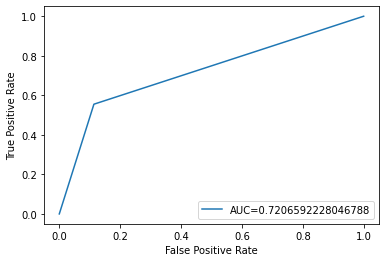

In [104]:
fpr, tpr, _ = roc_curve(testY, preidctY)
auc = roc_auc_score(testY, preidctY)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## VI - Plot precision-recall curve for different thresholds and discuss the plot

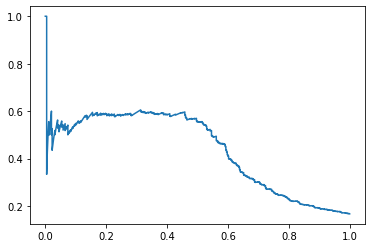

In [105]:
yScore = model.predict_proba(testX)[: , 1]
p, r, t = precision_recall_curve(testY, yScore)
plt.plot(r,p)

# 5 - Softmax Regressien

## I - How softmax regression is related to logistic regression? What library can you use for softmax regression?

Softmax is a version of linear regression that allows for the classification of multiple classes instedad of a binary classification of logistic regression


# 6 - KNN

## 1 - Use sklearn's KNN classifier to train (with k=  10) and predict the model based on the unbalanced training set (the training set before rebalancing) and test it and show the confusion matrix and classification report

In [106]:
KNN = KNeighborsClassifier(n_neighbors = 10)
KNN.fit(trainXO, trainYO)
perdictY = KNN.predict(testX)
print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY))

[[1987  255]
 [ 198  247]] 
               precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      2242
         1.0       0.49      0.56      0.52       445

    accuracy                           0.83      2687
   macro avg       0.70      0.72      0.71      2687
weighted avg       0.84      0.83      0.84      2687



## 2 - Use sklearn's KNN classifier to train (with k=  10) and predict the model based on the rebalanced training set and test it and show the confusion matrix and classification report

In [107]:
KNN = KNeighborsClassifier(n_neighbors = 10)
KNN.fit(trainX, trainY)
perdictY = KNN.predict(testX)
print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY))

[[1987  255]
 [ 198  247]] 
               precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      2242
         1.0       0.49      0.56      0.52       445

    accuracy                           0.83      2687
   macro avg       0.70      0.72      0.71      2687
weighted avg       0.84      0.83      0.84      2687



## 3 - Use grid search to tune the following hyperparameters of KNN: number of neighbors (between 1 and 20), weights  (uniform or distance), and metrics (Euclidean, Manhattan, or Minkowski)istance) to use for KNN

In [108]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
gs = GridSearchCV(KNeighborsClassifier(), param_grid = {'n_neighbors' : range(1,20), 'weights' : ['uniform', 'distance'], 'metric' : ['euclidean', 'manhattan', 'minkowski']}
, scoring = scoring, refit = 'AUC', return_train_score = True, n_jobs = -1)
gs.fit(trainX, trainY)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

## 4 - The above grid search process can take a couple of minutes. After completing the process, print the best_params_

In [109]:
gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

## 5 - Based on the result from grid search, use the parameters to train a model, test it with test set, and then print the confusion matrix and classification report. Also, show the AUC of ROC.

In [110]:
KNN = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 5, weights = 'distance')
KNN.fit(trainX, trainY)
predictY = KNN.predict(testX)
propY = KNN.predict_proba(testX)
print(confusion_matrix(testY, predictY), '\n', classification_report(testY, predictY), '\n', roc_auc_score(testY, preidctY))

[[1777  465]
 [ 187  258]] 
               precision    recall  f1-score   support

         0.0       0.90      0.79      0.84      2242
         1.0       0.36      0.58      0.44       445

    accuracy                           0.76      2687
   macro avg       0.63      0.69      0.64      2687
weighted avg       0.81      0.76      0.78      2687
 
 0.7206592228046788


## 6 - Use PCA and based on that train model, test it and then print the confusion matrix and classification report. Also, show the AUC of ROC.

In [111]:
def getModels():
	models = dict()
	for i in range(1, 32):
		steps = [('pca', PCA(n_components = i)), ('m', KNeighborsClassifier(metric = 'manhattan', n_neighbors = 5, weights = 'distance'))]
		models[str(i)] = Pipeline(steps = steps)
	return models

def evalModel(modes, X, y):
	cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
	scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv, n_jobs = 1, error_score = 'raise')
	return scores

In [112]:
models = getModels()
results, names = list(), list()
for name, model in models.items():
	scores = evalModel(model, trainX, trainY)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>1 0.636 (0.014)
>2 0.721 (0.010)
>3 0.782 (0.012)
>4 0.796 (0.013)
>5 0.807 (0.012)
>6 0.812 (0.013)
>7 0.814 (0.012)
>8 0.823 (0.013)
>9 0.829 (0.013)
>10 0.836 (0.013)
>11 0.843 (0.012)
>12 0.846 (0.014)
>13 0.845 (0.014)
>14 0.847 (0.012)
>15 0.848 (0.012)
>16 0.851 (0.011)
>17 0.850 (0.012)
>18 0.851 (0.013)
>19 0.853 (0.012)
>20 0.853 (0.013)
>21 0.853 (0.013)
>22 0.854 (0.012)
>23 0.853 (0.012)
>24 0.854 (0.012)
>25 0.854 (0.012)
>26 0.854 (0.012)
>27 0.854 (0.012)
>28 0.854 (0.012)
>29 0.854 (0.012)
>30 0.854 (0.012)
>31 0.854 (0.012)


In [113]:
steps = [('pca', PCA(n_components = 20)), ('m', KNeighborsClassifier(metric = 'manhattan', n_neighbors = 5, weights = 'distance'))]
model = Pipeline(steps = steps)
model.fit(trainX, trainY)
preidctY = model.predict(testX)

print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY), '\n', roc_auc_score(testY, preidctY))

[[1696  546]
 [ 167  278]] 
               precision    recall  f1-score   support

         0.0       0.91      0.76      0.83      2242
         1.0       0.34      0.62      0.44       445

    accuracy                           0.73      2687
   macro avg       0.62      0.69      0.63      2687
weighted avg       0.82      0.73      0.76      2687
 
 0.6905932704547506


## 7 - A short discussion on the 4 models and their differences

The first model used an imballenced dataset, while it is more representative of out data as a whole it makes it harded for the model to learn a difference between the two classes
The second model using the ballenced dataset learns the difference between the 2 classes better
the third model is fined tuned using grid search so it can learn the classes better
the fourth model is dimensionally optimised to reduce training time

# 7 - Niave Bayes

## 1 - Train a model with GaussianNB, test it and then print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification.

[[1117 1125]
 [ 106  339]] 
               precision    recall  f1-score   support

         0.0       0.91      0.50      0.64      2242
         1.0       0.23      0.76      0.36       445

    accuracy                           0.54      2687
   macro avg       0.57      0.63      0.50      2687
weighted avg       0.80      0.54      0.60      2687
 



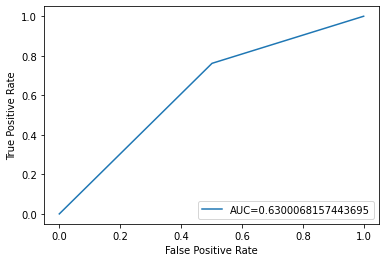

Number of missclassifications:  1231


In [114]:
GNB = GaussianNB()
GNB.fit(trainX, trainY)
preidctY = GNB.predict(testX)

print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY), '\n')
fpr, tpr, _ = roc_curve(testY, preidctY)
auc = roc_auc_score(testY, preidctY)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('Number of missclassifications: ', (testY != preidctY).sum())

## 2 - Train a model with CategoricalNB, test it and then print the confusion matrix and classification report. Also, plot ROC curve, and show the AUC of ROC and the count of the number of misclassification.


[[1904  338]
 [ 205  240]] 
               precision    recall  f1-score   support

         0.0       0.90      0.85      0.88      2242
         1.0       0.42      0.54      0.47       445

    accuracy                           0.80      2687
   macro avg       0.66      0.69      0.67      2687
weighted avg       0.82      0.80      0.81      2687
 



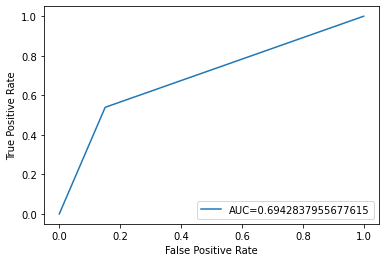

Number of missclassifications:  543


In [115]:
CNB = CategoricalNB()
CNB.fit(trainX, trainY)
preidctY = CNB.predict(testX)

print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY), '\n')
fpr, tpr, _ = roc_curve(testY, preidctY)
auc = roc_auc_score(testY, preidctY)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('Number of missclassifications: ', (testY != preidctY).sum())

# 8 - Support Vector Machine

## 1 - Build a support vector machine model using SVC. Use grid search to tune some parameters and then based on that show the best parameters found

In [116]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
gs = GridSearchCV(SVC(), param_grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' : range(1,10)}
, scoring = scoring, refit = 'AUC', return_train_score = True, n_jobs = -1)
gs.fit(trainX, trainY)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'degree': range(1, 10),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [117]:
gs.best_params_

{'degree': 9, 'kernel': 'poly'}

## 2 - Test the model and print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification.

In [121]:
SVM = SVC(kernel = 'poly', degree = 9)
SVM.fit(trainX, trainY)
preidctY = SVM.predict(testX)


[[1840  402]
 [ 187  258]] 
               precision    recall  f1-score   support

         0.0       0.91      0.82      0.86      2242
         1.0       0.39      0.58      0.47       445

    accuracy                           0.78      2687
   macro avg       0.65      0.70      0.66      2687
weighted avg       0.82      0.78      0.80      2687
 



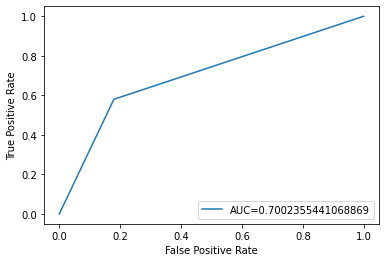

Number of missclassifications:  589


In [122]:
print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY), '\n')
fpr, tpr, _ = roc_curve(testY, preidctY)
auc = roc_auc_score(testY, preidctY)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('Number of missclassifications: ', (testY != preidctY).sum())

# 9 - Decisien Tree

## 1 - Build a decision tree model using sklearns DecisionTreeClassifier. Use the unbalanced training set, entropy as the criterion. Try with different max_depth (or use grid search). After building model, test it and print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification. Show the decision tree.

In [123]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
gs = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'), param_grid = {'max_depth' : range(1,50), 'min_samples_split' : range(2,20), 'min_samples_leaf' : range(1,20)},
scoring = scoring, refit = 'AUC', return_train_score = True, n_jobs = -1)
gs.fit(trainXO, trainYO)

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy'), n_jobs=-1,
             param_grid={'max_depth': range(1, 50),
                         'min_samples_leaf': range(1, 20),
                         'min_samples_split': range(2, 20)},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [124]:
gs.best_params_

{'max_depth': 4, 'min_samples_leaf': 19, 'min_samples_split': 2}

In [125]:
DT = DecisionTreeClassifier(max_depth=4, min_samples_leaf=19, min_samples_split=2)
DT.fit(trainXO, trainYO)
preidctY = DT.predict(testX)

[Text(0.5, 0.9, 'X[1] <= 0.352\ngini = 0.276\nsamples = 6268\nvalue = [5230, 1038]'),
 Text(0.28846153846153844, 0.7, 'X[3] <= 0.69\ngini = 0.484\nsamples = 944\nvalue = [387, 557]'),
 Text(0.15384615384615385, 0.5, 'X[0] <= 0.269\ngini = 0.478\nsamples = 879\nvalue = [348, 531]'),
 Text(0.07692307692307693, 0.3, 'X[0] <= 0.245\ngini = 0.433\nsamples = 224\nvalue = [71, 153]'),
 Text(0.038461538461538464, 0.1, 'gini = 0.451\nsamples = 204\nvalue = [70, 134]'),
 Text(0.11538461538461539, 0.1, 'gini = 0.095\nsamples = 20\nvalue = [1, 19]'),
 Text(0.23076923076923078, 0.3, 'X[0] <= 0.529\ngini = 0.488\nsamples = 655\nvalue = [277, 378]'),
 Text(0.19230769230769232, 0.1, 'gini = 0.5\nsamples = 237\nvalue = [119, 118]'),
 Text(0.2692307692307692, 0.1, 'gini = 0.47\nsamples = 418\nvalue = [158, 260]'),
 Text(0.4230769230769231, 0.5, 'X[2] <= 0.25\ngini = 0.48\nsamples = 65\nvalue = [39, 26]'),
 Text(0.38461538461538464, 0.3, 'X[0] <= 0.598\ngini = 0.439\nsamples = 40\nvalue = [27, 13]'),
 Te

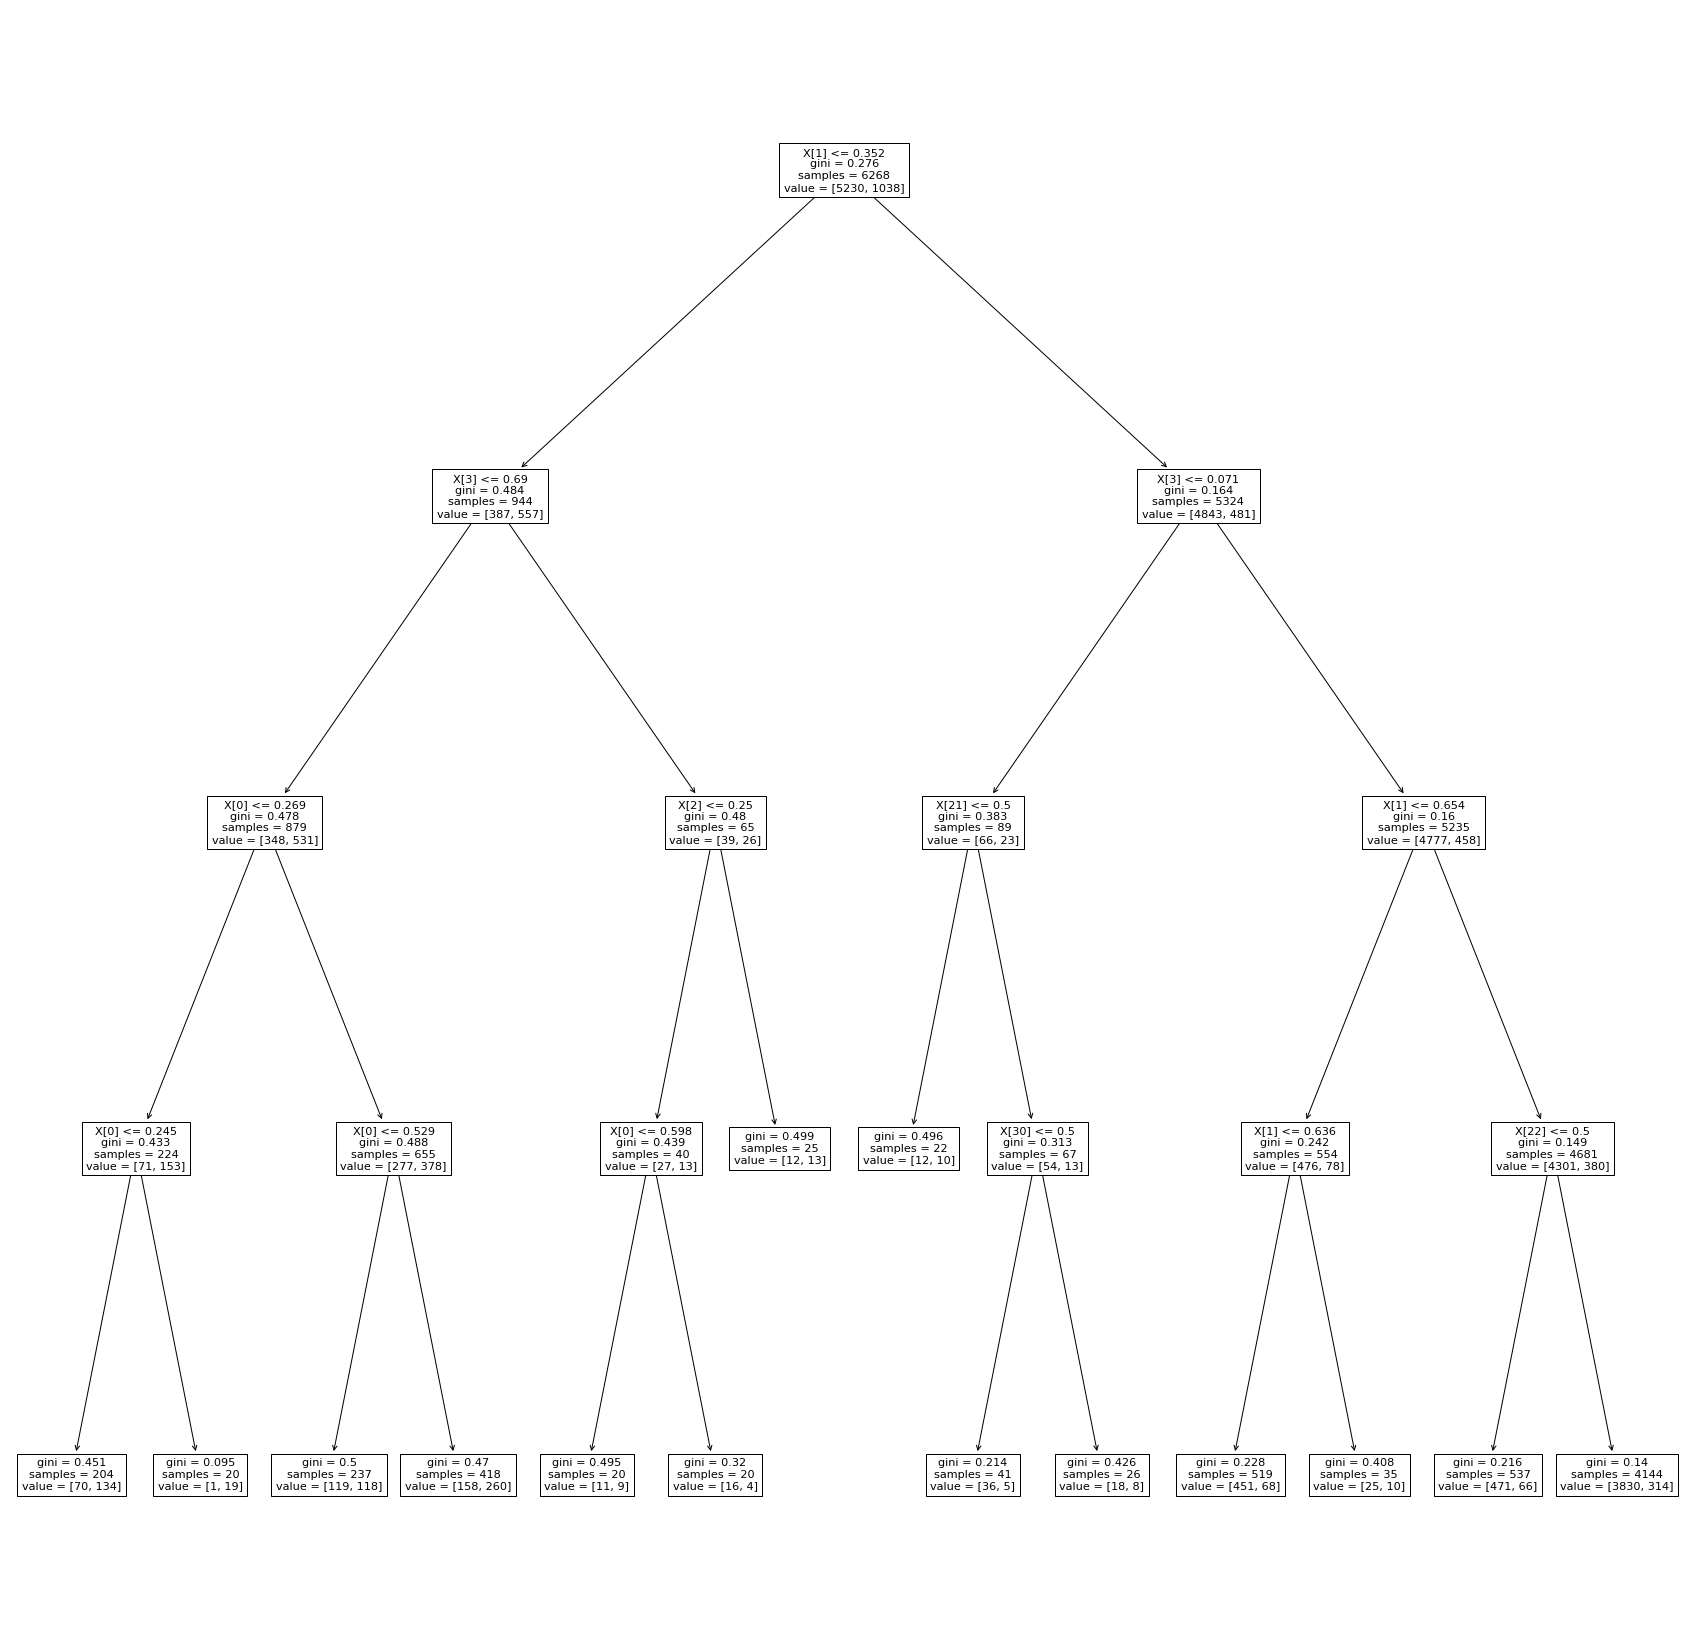

In [126]:
plt.figure(figsize=(30,30))
skt.plot_tree(DT)

[[2118  124]
 [ 275  170]] 
               precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      2242
         1.0       0.58      0.38      0.46       445

    accuracy                           0.85      2687
   macro avg       0.73      0.66      0.69      2687
weighted avg       0.83      0.85      0.84      2687
 



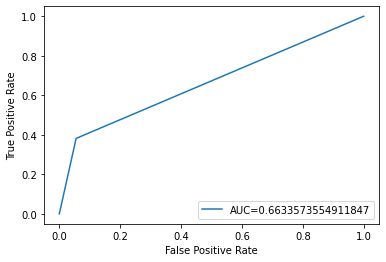

Number of missclassifications:  399


In [127]:
print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY), '\n')
fpr, tpr, _ = roc_curve(testY, preidctY)
auc = roc_auc_score(testY, preidctY)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('Number of missclassifications: ', (testY != preidctY).sum())

## 2 - Perform the same tasks as 9.1 with the balanced training set

In [128]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
gs = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'), param_grid = {'max_depth' : range(1,50), 'min_samples_split' : range(2,20), 'min_samples_leaf' : range(1,20)},
scoring = scoring, refit = 'AUC', return_train_score = True, n_jobs = -1)
gs.fit(trainX, trainY)

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy'), n_jobs=-1,
             param_grid={'max_depth': range(1, 50),
                         'min_samples_leaf': range(1, 20),
                         'min_samples_split': range(2, 20)},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [129]:
gs.best_params_

{'max_depth': 17, 'min_samples_leaf': 11, 'min_samples_split': 12}

In [130]:
DT = DecisionTreeClassifier(max_depth=33, min_samples_leaf=11, min_samples_split=8)
DT.fit(trainXO, trainYO)
preidctY = DT.predict(testX)

[Text(0.22917633190138342, 0.9814814814814815, 'X[1] <= 0.352\ngini = 0.276\nsamples = 6268\nvalue = [5230, 1038]'),
 Text(0.12623031496062992, 0.9444444444444444, 'X[3] <= 0.69\ngini = 0.484\nsamples = 944\nvalue = [387, 557]'),
 Text(0.06654636920384951, 0.9074074074074074, 'X[0] <= 0.269\ngini = 0.478\nsamples = 879\nvalue = [348, 531]'),
 Text(0.019247594050743656, 0.8703703703703703, 'X[0] <= 0.245\ngini = 0.433\nsamples = 224\nvalue = [71, 153]'),
 Text(0.015748031496062992, 0.8333333333333334, 'X[1] <= 0.218\ngini = 0.451\nsamples = 204\nvalue = [70, 134]'),
 Text(0.008748906386701663, 0.7962962962962963, 'X[3] <= 0.214\ngini = 0.5\nsamples = 30\nvalue = [15, 15]'),
 Text(0.005249343832020997, 0.7592592592592593, 'gini = 0.355\nsamples = 13\nvalue = [10, 3]'),
 Text(0.012248468941382326, 0.7592592592592593, 'gini = 0.415\nsamples = 17\nvalue = [5, 12]'),
 Text(0.022747156605424323, 0.7962962962962963, 'X[24] <= 0.5\ngini = 0.432\nsamples = 174\nvalue = [55, 119]'),
 Text(0.01924

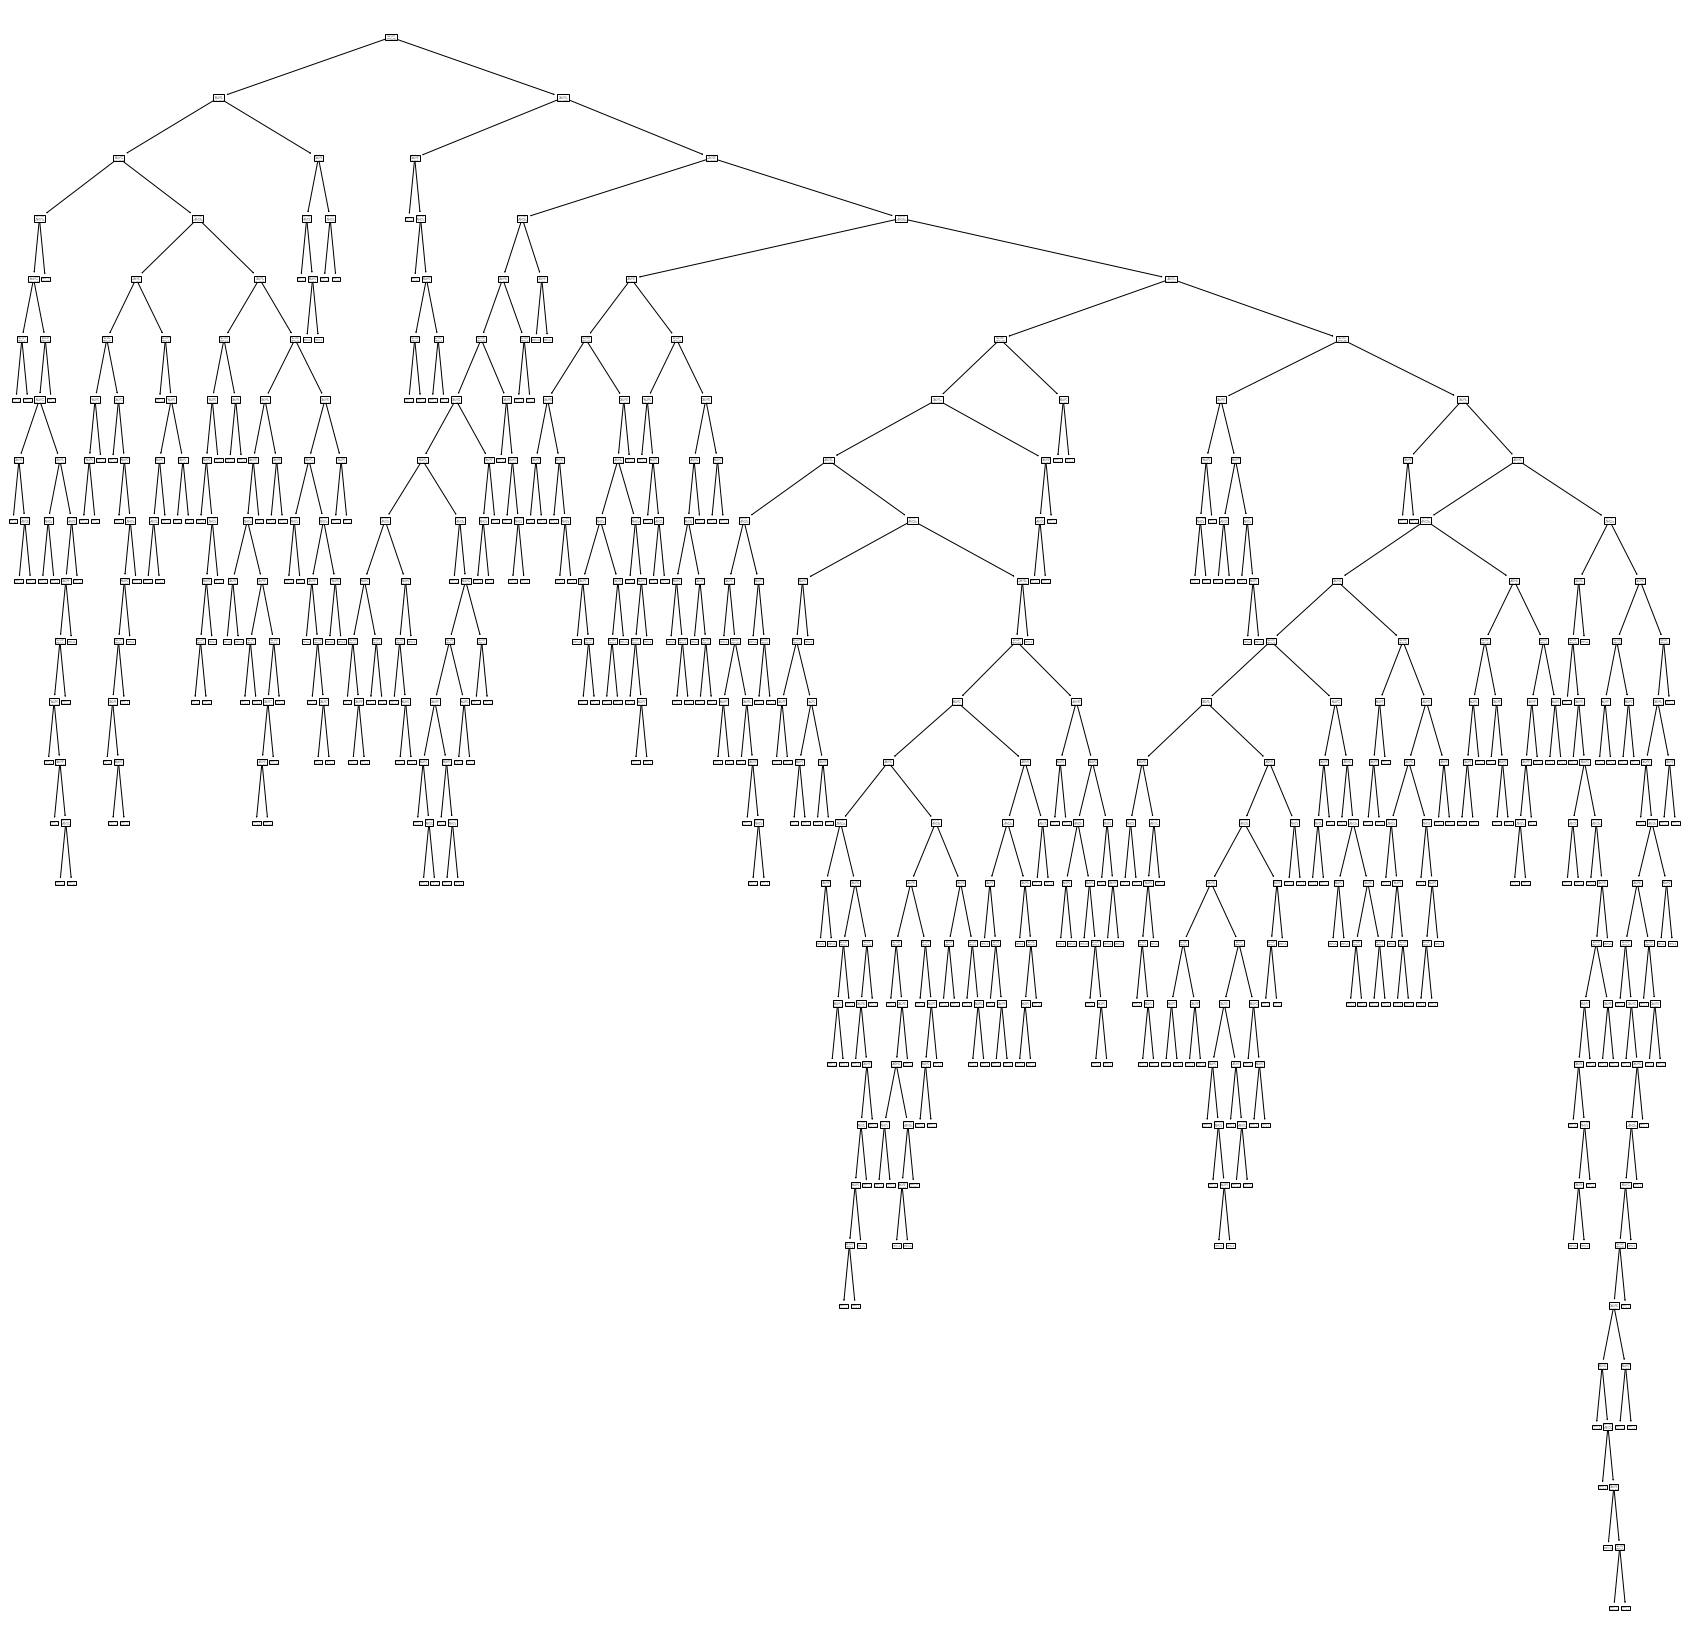

In [131]:
plt.figure(figsize=(30,30))
skt.plot_tree(DT)

[[2135  107]
 [ 311  134]] 
               precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      2242
         1.0       0.56      0.30      0.39       445

    accuracy                           0.84      2687
   macro avg       0.71      0.63      0.65      2687
weighted avg       0.82      0.84      0.82      2687
 



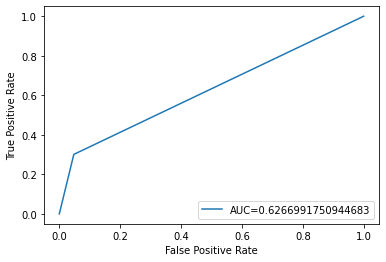

Number of missclassifications:  418


In [132]:
print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY), '\n')
fpr, tpr, _ = roc_curve(testY, preidctY)
auc = roc_auc_score(testY, preidctY)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('Number of missclassifications: ', (testY != preidctY).sum())

## 3 - Discuss any difference and also discuss part of the tree of 9.2


the second tree is deeper and more expansive than the first, but fits the data better


# 10 - Random Forest 

## 1 - Use grid search to tune the max_depth, min_samples_leaf, and n_estimators

In [133]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
gs = GridSearchCV(RandomForestClassifier(criterion='entropy'), param_grid = {'n_estimators' : range(1,100,10), 'min_samples_leaf' : range(1,10), 'max_depth' : range(2,10)},
scoring = scoring, refit = 'AUC', return_train_score = True, n_jobs = -1)
gs.fit(trainX, trainY)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy'), n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(1, 10),
                         'n_estimators': range(1, 100, 10)},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

## 2 - Print the best estimator

In [134]:
gs.best_params_

{'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 91}

## 3 - Train the model. After building the model, test it and print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification.

In [135]:

RF = RandomForestClassifier(criterion='entropy', n_estimators=91, min_samples_leaf=1, max_depth=9)
RF.fit(trainX, trainY)
preidctY = RF.predict(testX)

[[2059  183]
 [ 201  244]] 
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      2242
         1.0       0.57      0.55      0.56       445

    accuracy                           0.86      2687
   macro avg       0.74      0.73      0.74      2687
weighted avg       0.85      0.86      0.86      2687
 



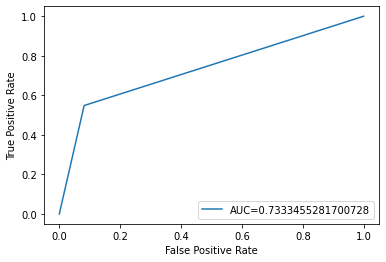

Number of missclassifications:  384


In [136]:
print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY), '\n')
fpr, tpr, _ = roc_curve(testY, preidctY)
auc = roc_auc_score(testY, preidctY)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('Number of missclassifications: ', (testY != preidctY).sum())

# 11 - Boosting Algorithms

## 1 - Train an AdaBoostClassifier model with some manual/grid search-based parameters and then test it and then print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification.

In [137]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
gs = GridSearchCV(AdaBoostClassifier(), param_grid = {'n_estimators' : range(1,111,10), 'learning_rate' : range(1,10)},
scoring = scoring, refit = 'AUC', return_train_score = True, n_jobs = -1)
gs.fit(trainX, trainY)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': range(1, 10),
                         'n_estimators': range(1, 111, 10)},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [138]:
gs.best_params_

{'learning_rate': 1, 'n_estimators': 101}

In [139]:
ADA = AdaBoostClassifier(n_estimators=101, learning_rate=1)
ADA.fit(trainX, trainY)
preidctY  = ADA.predict(testX)

[[2060  182]
 [ 207  238]] 
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      2242
         1.0       0.57      0.53      0.55       445

    accuracy                           0.86      2687
   macro avg       0.74      0.73      0.73      2687
weighted avg       0.85      0.86      0.85      2687
 



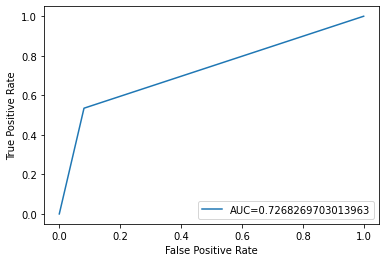

Number of missclassifications:  389


In [140]:
print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY), '\n')
fpr, tpr, _ = roc_curve(testY, preidctY)
auc = roc_auc_score(testY, preidctY)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('Number of missclassifications: ', (testY != preidctY).sum())

## 2 - Do the same for Gradient BoostingClassifier

In [141]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
gs = GridSearchCV(GradientBoostingClassifier(), param_grid = {'loss' : ['deviance', 'exponential'], 'learning_rate' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 'n_estimators' : range(10, 250,10), 'criterion' : ['friedman_mse', 'squared_error']},
scoring = scoring, refit = 'AUC', return_train_score = True, n_jobs = 10)
gs.fit(trainX, trainY)

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=10,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9, 1],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': range(10, 250, 10)},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [142]:
gs.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'exponential',
 'n_estimators': 210}

In [143]:
GBC = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.2, loss='exponential', n_estimators=150)
GBC.fit(trainX, trainY)
predictY = GBC.predict(testX)

[[2060  182]
 [ 207  238]] 
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      2242
         1.0       0.57      0.53      0.55       445

    accuracy                           0.86      2687
   macro avg       0.74      0.73      0.73      2687
weighted avg       0.85      0.86      0.85      2687
 



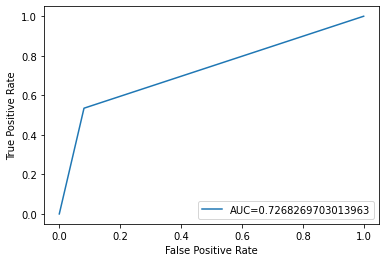

Number of missclassifications:  389


In [144]:
print(confusion_matrix(testY, preidctY), '\n', classification_report(testY, preidctY), '\n')
fpr, tpr, _ = roc_curve(testY, preidctY)
auc = roc_auc_score(testY, preidctY)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('Number of missclassifications: ', (testY != preidctY).sum())

# 12 - briefly discuss your finding such as which model could be most suitable for this given scenario and what could be your future work based on this experiment.

for this given sceneries random forest seems to perform the best at differentiating the classes
based on this i can try fine tuning a few of the models more to try to get an even better classifier

In [145]:
print("***** DONE *****")

***** DONE *****
